<a href="https://colab.research.google.com/github/jd2504/bme_dsp_2025/blob/main/02_bird_chirps.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
from scipy import io as sio
from scipy import signal, stats
from matplotlib import pyplot as plt
import math

from scipy.linalg import toeplitz

from sklearn.metrics import root_mean_squared_error, mean_squared_error
from sklearn.model_selection import train_test_split, KFold

import requests
import io

from tqdm import tqdm

In [2]:
def grab_file(filename):
    PARENT = 'https://parralab.org/teaching/biomed-dsp/'
    FILENAME = filename
    FULLPATH = PARENT+FILENAME
    print(FULLPATH)

    response = requests.get(FULLPATH)
    data_stream = io.BytesIO(response.content)

    return data_stream


def grab_mat(mat_file):
    data_stream = grab_file(mat_file)
    mat_contents = sio.loadmat(data_stream)

    return mat_contents


def grab_wav(wav_file):
    audio_bytes = grab_file(wav_file)
    fs, data = sio.wavfile.read(audio_bytes)

    return fs, data

In [3]:
def est_ma_filter(sig_in, sig_out, Q):
    x = sig_in
    y = sig_out
    n_coeffs = Q+1

    # avoid edge artifacts
    y_vec = y[Q:]
    col = x[Q:]
    row = x[Q::-1][:n_coeffs]

    X = toeplitz(col, row)
    b_hat, _, _, _ = np.linalg.lstsq(X, y_vec)

    return b_hat

In [4]:
def find_best_q_cv(sig_in, sig_out, q_range, k=5):
    kf = KFold(n_splits=k)
    q_errors_val = {}
    q_errors_train = {}

    for q in tqdm(q_range):
        n_coeffs = q + 1
        y_vec = sig_out[q:]
        col = sig_in[q:]
        row = sig_in[q::-1][:n_coeffs]
        X = toeplitz(col, row)

        n_samps = min(len(y_vec), X.shape[0])
        X = X[:n_samps, :]
        y_vec = y_vec[:n_samps]

        errors_val = []
        errors_train = []
        for train_idx, val_idx in kf.split(X):
            X_train, X_val = X[train_idx], X[val_idx]
            y_train, y_val = y_vec[train_idx], y_vec[val_idx]

            b_hat, _, _, _ = np.linalg.lstsq(X_train, y_train)

            y_pred_val = X_val @ b_hat
            y_pred_train = X_train @ b_hat
            mse_val = np.mean((y_val - y_pred_val)**2)
            mse_train = np.mean((y_train - y_pred_train)**2)
            errors_val.append(mse_val)
            errors_train.append(mse_train)

        if errors_val:
            q_errors_val[q] = np.mean(errors_val)
            q_errors_train[q] = np.mean(errors_train)
            print(f'q={q}, mean cv mse={q_errors_val[q]:.4f}')


    best_q = min(q_errors_val, key=q_errors_val.get)
    return best_q, q_errors_val, q_errors_train

# Part 1 - bird chirps

In [5]:
fs, birds = grab_wav('bird-stereo.wav')

print(f"file length: {birds.shape[0]/fs:.3f}s at {fs}kHz")

mic1 = birds[:, 0]
mic2 = birds[:, 1]

mic1 = mic1 / np.max(np.abs(mic1))
mic2 = mic2 / np.max(np.abs(mic2))

# sec; time axis
s = birds.shape[0]/fs
t = np.linspace(0, s, birds.shape[0])

https://parralab.org/teaching/biomed-dsp/bird-stereo.wav
file length: 2.205s at 44100kHz


/tmp/ipython-input-3391966722.py:22: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, data = sio.wavfile.read(audio_bytes)


In [6]:
# tested 120-1000 in tens -> result 360
# tested 300-450 in ones -> result 363

q_range = [i for i in range(330, 390, 3)]
best_q, q_errors_val, q_errors_train = find_best_q_cv(mic1, mic2, q_range)

  5%|▌         | 1/20 [00:08<02:33,  8.06s/it]

q=330, mean cv mse=0.0026


 10%|█         | 2/20 [00:15<02:18,  7.69s/it]

q=333, mean cv mse=0.0024


 15%|█▌        | 3/20 [00:22<02:02,  7.19s/it]

q=336, mean cv mse=0.0022


 20%|██        | 4/20 [00:29<01:58,  7.40s/it]

q=339, mean cv mse=0.0022


 25%|██▌       | 5/20 [00:37<01:54,  7.65s/it]

q=342, mean cv mse=0.0021


 30%|███       | 6/20 [00:44<01:44,  7.45s/it]

q=345, mean cv mse=0.0020


 35%|███▌      | 7/20 [00:53<01:40,  7.72s/it]

q=348, mean cv mse=0.0019


 40%|████      | 8/20 [01:01<01:35,  7.97s/it]

q=351, mean cv mse=0.0018


 45%|████▌     | 9/20 [01:09<01:25,  7.76s/it]

q=354, mean cv mse=0.0017


 50%|█████     | 10/20 [01:16<01:17,  7.79s/it]

q=357, mean cv mse=0.0017


 55%|█████▌    | 11/20 [01:25<01:11,  7.94s/it]

q=360, mean cv mse=0.0017


 60%|██████    | 12/20 [01:32<01:01,  7.75s/it]

q=363, mean cv mse=0.0017


 65%|██████▌   | 13/20 [01:41<00:55,  7.98s/it]

q=366, mean cv mse=0.0017


 70%|███████   | 14/20 [01:49<00:48,  8.11s/it]

q=369, mean cv mse=0.0017


 75%|███████▌  | 15/20 [01:57<00:40,  8.01s/it]

q=372, mean cv mse=0.0017


 80%|████████  | 16/20 [02:05<00:32,  8.22s/it]

q=375, mean cv mse=0.0018


 85%|████████▌ | 17/20 [02:14<00:25,  8.41s/it]

q=378, mean cv mse=0.0018


 90%|█████████ | 18/20 [02:23<00:17,  8.59s/it]

q=381, mean cv mse=0.0018


 95%|█████████▌| 19/20 [02:31<00:08,  8.25s/it]

q=384, mean cv mse=0.0019


100%|██████████| 20/20 [02:39<00:00,  7.97s/it]

q=387, mean cv mse=0.0020


[DO NOT RERUN...] Plot from previous run - range(120, 1000, 10):

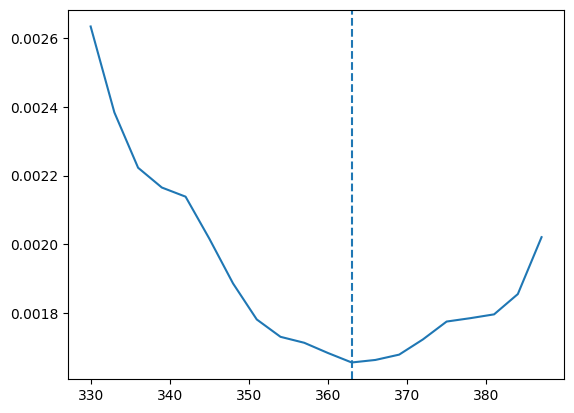

In [7]:
plt.plot(list(q_errors_val.keys()), list(q_errors_val.values()))
plt.axvline(x=best_q, ls="--")
plt.show()

[DO NOT RERUN...] Also from previous run - range(300, 450):

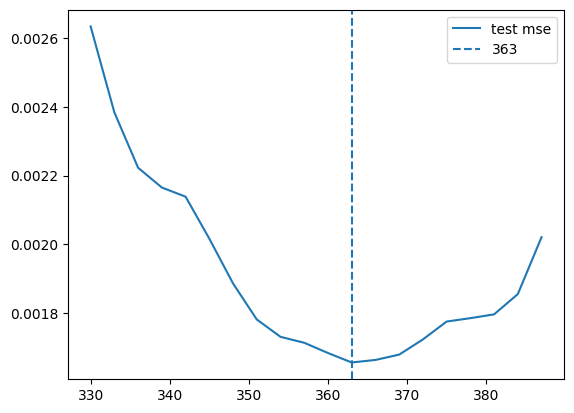

In [8]:
plt.plot(list(q_errors_val.keys()), list(q_errors_val.values()), label="test mse")
plt.axvline(x=best_q, ls="--", label=f"{best_q}")
plt.legend()
plt.show()

Using range, above - range(330, 390, 3):

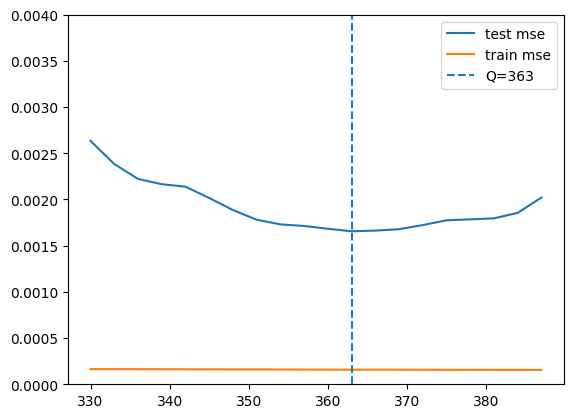

In [9]:
plt.plot(list(q_errors_val.keys()), list(q_errors_val.values()), label="test mse")
plt.plot(list(q_errors_train.keys()), list(q_errors_train.values()), label="train mse")
plt.axvline(x=best_q, ls="--", label=f"Q={best_q}")
plt.legend()
plt.ylim(0,0.004)
plt.show()

In [10]:
Q = min(q_errors_val, key=q_errors_val.get)
# Q = 363
print(f'min Q by test error: {Q}')

bird_b = est_ma_filter(mic1, mic2, Q)

mic2_est = signal.convolve(mic1, bird_b, mode='full')[:len(mic1)]
rmse = root_mean_squared_error(mic2, mic2_est)
print(f'Q={Q} RMSE: {rmse:.2f}')
resids = mic2 - mic2_est

ms_b = (bird_b.shape[0]/fs)*1000
x_b = np.linspace(0, ms_b, bird_b.shape[0])

# mic distance estimate : dist = speed of sound * peak impulse response
peak_idx = np.argmax(np.abs(bird_b))
delay_s = peak_idx/fs

sound_mps = 343
dist_m = sound_mps * delay_s
dist_cm = dist_m*100

min Q by test error: 363
Q=363 RMSE: 0.01


## Part 1 answer

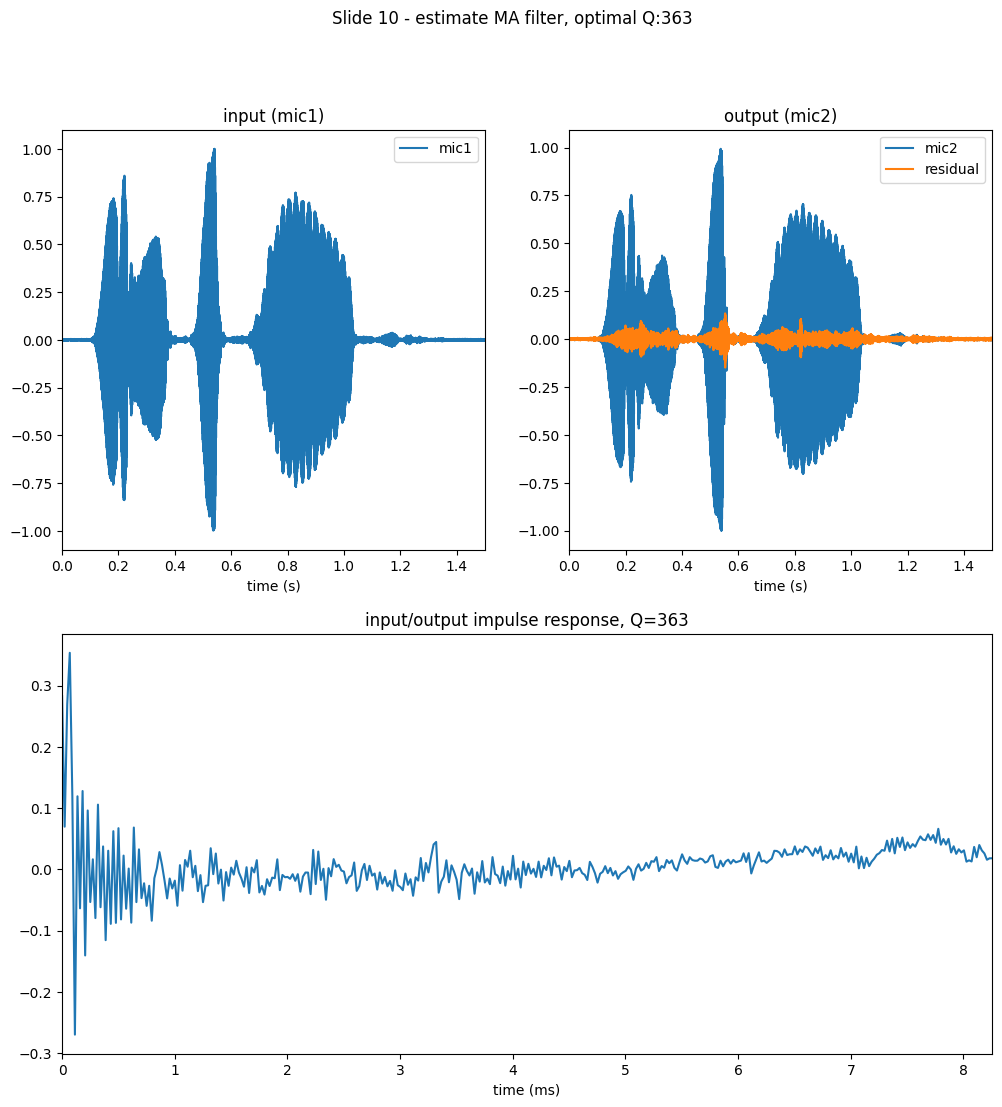

In [11]:
plt.figure(figsize=(12, 12))
plt.suptitle(f'Slide 10 - estimate MA filter, optimal Q:{Q}')

ax1 = plt.subplot(2, 2, 1) # mic1
ax2 = plt.subplot(2, 2, 2) # mic2
ax3 = plt.subplot(2, 1, 2) # impulse response

ax1.plot(t, mic1, label='mic1')
ax1.set_xlim(0, 1.5)
ax1.set_title('input (mic1)')
ax1.set_xlabel('time (s)')
ax1.legend()

ax2.plot(t, mic2, label='mic2')
ax2.plot(t, resids, label='residual')
ax2.set_xlim(0, 1.5)
ax2.set_title('output (mic2)')
ax2.set_xlabel('time (s)')
ax2.legend()

ax3.plot(x_b, bird_b)
ax3.set_xlim(0, x_b.max())
ax3.set_title(f'input/output impulse response, Q={Q}')
ax3.set_xlabel('time (ms)')

plt.savefig('joel_deerwester_hw2-sl10')
plt.show()

Distance bet. mics: ~2.3cm
Optimal Q for MA filter: 363
(Actual dist. depends on mic-subject position.)


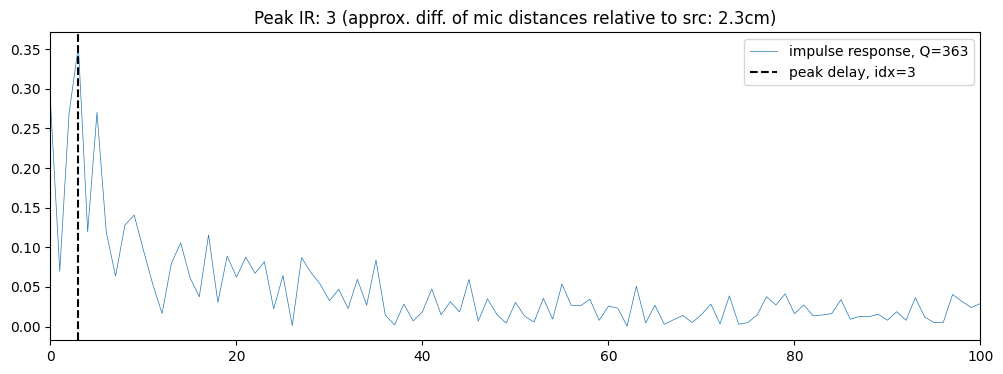

In [12]:
print(f'Distance bet. mics: ~{dist_cm:.1f}cm')
print(f'Optimal Q for MA filter: {Q}')
print('(Actual dist. depends on mic-subject position.)')


plt.figure(figsize=(12,4))
plt.title(f"Peak IR: {peak_idx} (approx. diff. of mic distances relative to src: {dist_cm:.1f}cm)")
plt.plot(np.abs(bird_b), label=f'impulse response, Q={Q}', lw=0.5)
plt.axvline(x=peak_idx, label=f'peak delay, idx={peak_idx}', c='black', ls='--')
plt.xlim(0, 100)
plt.legend()

plt.show()

# Part 2 - audio EEG

In [13]:
audio_eeg_raw = grab_mat('audio_eeg.mat')

fs_aud = int(audio_eeg_raw['fsAudio'][0][0])
fs_eeg = int(audio_eeg_raw['fsEEG'][0][0])

eeg = audio_eeg_raw['eeg1']
eeg_38 = eeg[:, 37]
eeg_38 = stats.zscore(eeg_38)
# eeg_34 = stats.zscore(eeg[:, 33])

audio_channel = audio_eeg_raw['audio'].T[0]

aud_s = eeg.shape[0]/fs_aud
aud_t = np.linspace(0, aud_s, eeg.shape[0])


print(f"eeg data contains {eeg.shape[0]/fs_eeg:.2f}s")

https://parralab.org/teaching/biomed-dsp/audio_eeg.mat
eeg data contains 500.05s


In [14]:
print(eeg_38.shape)
print(audio_channel.shape)

(64006,)
(22052119,)


In [15]:
def audio_envelope(audio_raw, fs_audio=fs_aud, fs_eeg=fs_eeg, n_eeg=eeg.shape[0], lowpass_cutoff=8.0):
    rectified_audio = np.abs(signal.hilbert(audio_raw))
    nyquist = fs_audio / 2.0
    b, a = signal.butter(2, lowpass_cutoff / nyquist, btype='low')
    audio_smoothed = signal.filtfilt(b, a, rectified_audio)

    envelope = signal.resample(audio_smoothed, n_eeg)

    return stats.zscore(envelope)


def audio_envelope_simplified(audio_raw, fs_audio=fs_aud, fs_eeg=fs_eeg, n_eeg=eeg.shape[0], lowpass_cutoff=8.0):
    # envelope = resample(abs(audio),length(eeg),length(audio));
    # simplified to reproduce the slide (plus hilbert transform) ... removed butterworth

    rectified_audio = np.abs(signal.hilbert(audio_raw))
    envelope = signal.resample(rectified_audio, n_eeg)

    return stats.zscore(envelope)

In [16]:
audio_envelope = audio_envelope(audio_channel)

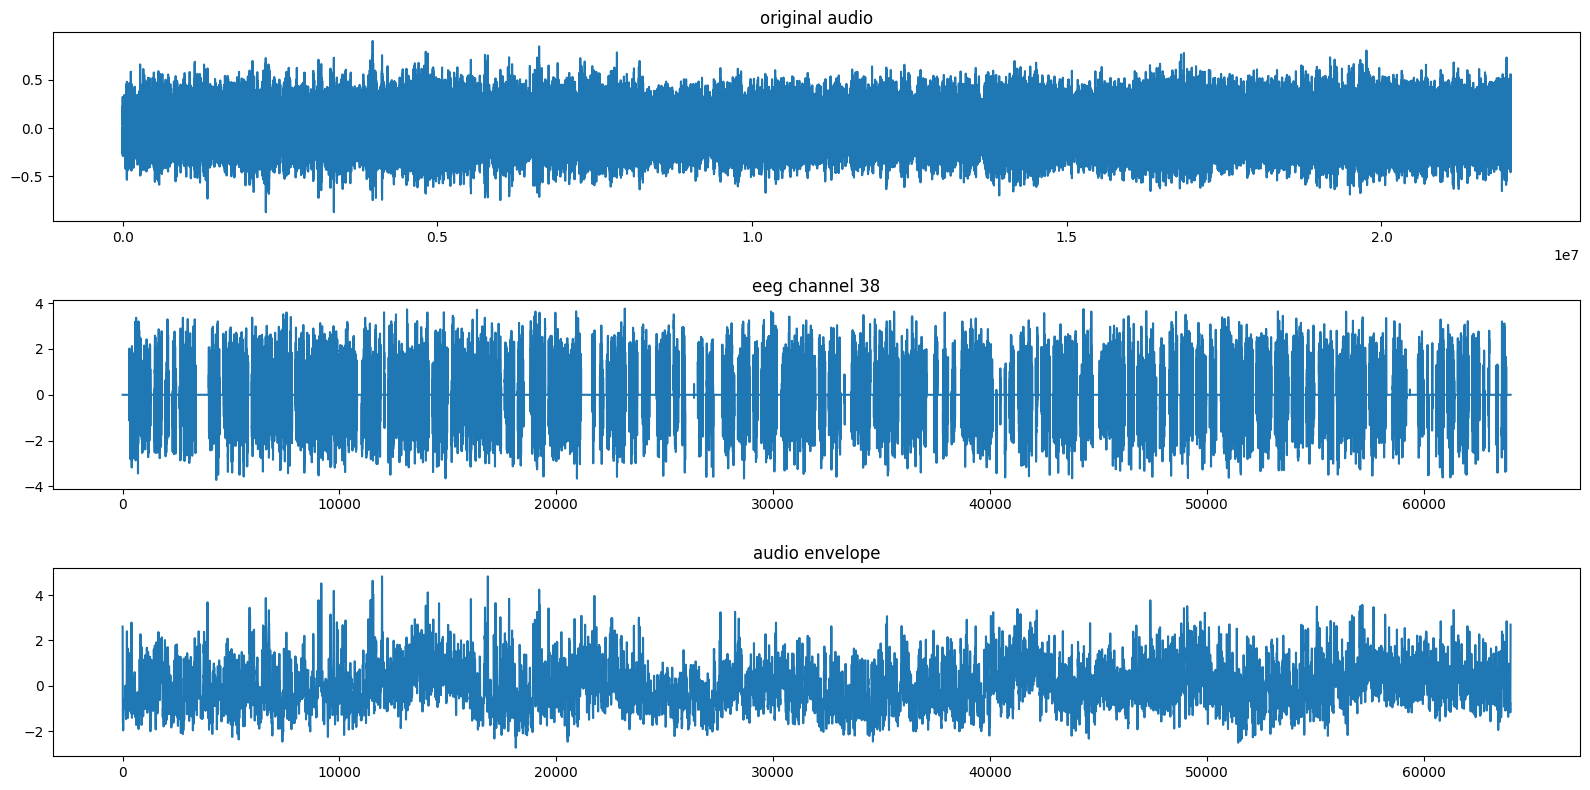

In [17]:
plt.figure(figsize=(16, 8))

plt.subplot(3, 1, 1)
plt.plot(audio_channel)
plt.title('original audio')
plt.subplot(3, 1, 2)
plt.plot(eeg_38)
plt.title('eeg channel 38')
plt.subplot(3, 1, 3)
plt.plot(audio_envelope)
plt.title('audio envelope')

plt.tight_layout()
plt.show()

In [18]:
print(int(len(audio_channel) * (fs_eeg/fs_aud)) == eeg.shape[0])
print(eeg.shape[0] == audio_envelope.shape[0])
print(audio_envelope.shape[0])

True
True
64006


In [19]:
# q_range = [i for i in range(256)]
q_range = [i for i in range(25, 76)]
aud_best_q, aud_q_errors_val, aud_q_errors_train = find_best_q_cv(audio_envelope, eeg_38, q_range)

  2%|▏         | 1/51 [00:00<00:08,  5.98it/s]

q=25, mean cv mse=1.0003


  4%|▍         | 2/51 [00:00<00:08,  5.95it/s]

q=26, mean cv mse=1.0004


  6%|▌         | 3/51 [00:00<00:07,  6.01it/s]

q=27, mean cv mse=1.0004


 10%|▉         | 5/51 [00:00<00:08,  5.70it/s]

q=28, mean cv mse=1.0004
q=29, mean cv mse=1.0004


 14%|█▎        | 7/51 [00:01<00:07,  5.88it/s]

q=30, mean cv mse=1.0003
q=31, mean cv mse=1.0002


 18%|█▊        | 9/51 [00:01<00:07,  5.95it/s]

q=32, mean cv mse=1.0002
q=33, mean cv mse=1.0000


 22%|██▏       | 11/51 [00:01<00:07,  5.52it/s]

q=34, mean cv mse=1.0000
q=35, mean cv mse=0.9999


 25%|██▌       | 13/51 [00:02<00:07,  5.33it/s]

q=36, mean cv mse=0.9999
q=37, mean cv mse=0.9998


 27%|██▋       | 14/51 [00:02<00:07,  5.02it/s]

q=38, mean cv mse=0.9998


 29%|██▉       | 15/51 [00:02<00:07,  4.83it/s]

q=39, mean cv mse=0.9998


 31%|███▏      | 16/51 [00:02<00:07,  4.65it/s]

q=40, mean cv mse=0.9998


 33%|███▎      | 17/51 [00:03<00:07,  4.53it/s]

q=41, mean cv mse=0.9997


 35%|███▌      | 18/51 [00:03<00:07,  4.36it/s]

q=42, mean cv mse=0.9996


 37%|███▋      | 19/51 [00:03<00:07,  4.12it/s]

q=43, mean cv mse=0.9997


 39%|███▉      | 20/51 [00:04<00:07,  4.00it/s]

q=44, mean cv mse=0.9997


 41%|████      | 21/51 [00:04<00:07,  3.91it/s]

q=45, mean cv mse=0.9998


 43%|████▎     | 22/51 [00:04<00:07,  3.76it/s]

q=46, mean cv mse=0.9998


 45%|████▌     | 23/51 [00:04<00:07,  3.66it/s]

q=47, mean cv mse=0.9998


 47%|████▋     | 24/51 [00:05<00:07,  3.56it/s]

q=48, mean cv mse=0.9999


 49%|████▉     | 25/51 [00:05<00:07,  3.44it/s]

q=49, mean cv mse=0.9999


 51%|█████     | 26/51 [00:05<00:07,  3.17it/s]

q=50, mean cv mse=1.0000


 53%|█████▎    | 27/51 [00:06<00:07,  3.04it/s]

q=51, mean cv mse=1.0001


 55%|█████▍    | 28/51 [00:06<00:07,  2.98it/s]

q=52, mean cv mse=1.0001


 57%|█████▋    | 29/51 [00:07<00:08,  2.68it/s]

q=53, mean cv mse=1.0001


 59%|█████▉    | 30/51 [00:08<00:12,  1.62it/s]

q=54, mean cv mse=1.0002


 61%|██████    | 31/51 [00:08<00:11,  1.72it/s]

q=55, mean cv mse=1.0002


 63%|██████▎   | 32/51 [00:09<00:10,  1.88it/s]

q=56, mean cv mse=1.0002


 65%|██████▍   | 33/51 [00:09<00:08,  2.01it/s]

q=57, mean cv mse=1.0003


 67%|██████▋   | 34/51 [00:10<00:08,  2.02it/s]

q=58, mean cv mse=1.0004


 69%|██████▊   | 35/51 [00:10<00:07,  2.06it/s]

q=59, mean cv mse=1.0005


 71%|███████   | 36/51 [00:10<00:07,  2.14it/s]

q=60, mean cv mse=1.0005


 73%|███████▎  | 37/51 [00:11<00:06,  2.15it/s]

q=61, mean cv mse=1.0005


 75%|███████▍  | 38/51 [00:11<00:06,  2.14it/s]

q=62, mean cv mse=1.0004


 76%|███████▋  | 39/51 [00:12<00:05,  2.08it/s]

q=63, mean cv mse=1.0004


 78%|███████▊  | 40/51 [00:12<00:05,  2.08it/s]

q=64, mean cv mse=1.0004


 80%|████████  | 41/51 [00:13<00:04,  2.01it/s]

q=65, mean cv mse=1.0005


 82%|████████▏ | 42/51 [00:13<00:04,  1.99it/s]

q=66, mean cv mse=1.0006


 84%|████████▍ | 43/51 [00:14<00:04,  1.94it/s]

q=67, mean cv mse=1.0007


 86%|████████▋ | 44/51 [00:14<00:03,  1.95it/s]

q=68, mean cv mse=1.0007


 88%|████████▊ | 45/51 [00:15<00:03,  1.83it/s]

q=69, mean cv mse=1.0007


 90%|█████████ | 46/51 [00:16<00:02,  1.78it/s]

q=70, mean cv mse=1.0007


 92%|█████████▏| 47/51 [00:16<00:02,  1.74it/s]

q=71, mean cv mse=1.0007


 94%|█████████▍| 48/51 [00:17<00:01,  1.69it/s]

q=72, mean cv mse=1.0007


 96%|█████████▌| 49/51 [00:18<00:01,  1.67it/s]

q=73, mean cv mse=1.0008


 98%|█████████▊| 50/51 [00:18<00:00,  1.47it/s]

q=74, mean cv mse=1.0008


100%|██████████| 51/51 [00:20<00:00,  2.50it/s]

q=75, mean cv mse=1.0008


In [20]:
aud_q_errors_val.keys() == aud_q_errors_train.keys()

True

## Part 2 answer

Best Q by min test MSE is 42.
Though there is a distinct min (left of min decreasing, right of min increasing), min RMSE is close to 1, indicating that Channel 38 TRF does not represent a strong response to the audio signal.


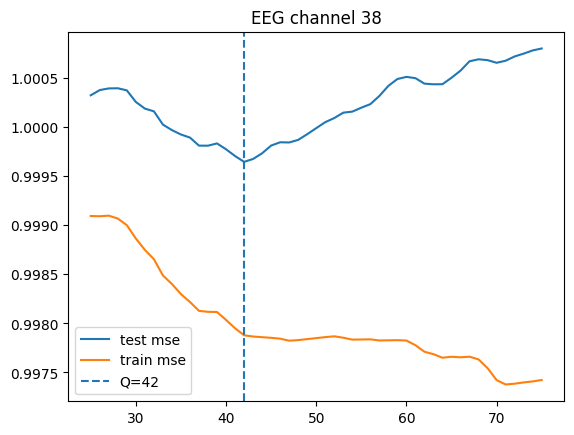



Channel 38 TRF with Q=42
Q=42 RMSE: 1.01


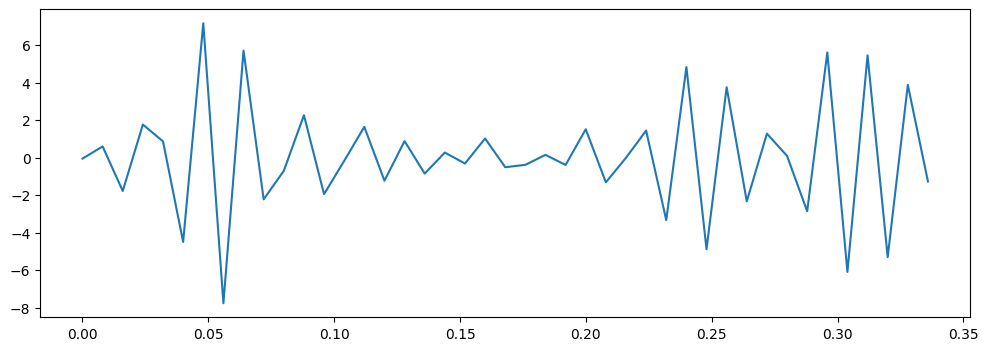

In [21]:
print(f'Best Q by min test MSE is {aud_best_q}.')
print('Though there is a distinct min (left of min decreasing, right of min increasing), min RMSE is close to 1, indicating that Channel 38 TRF does not represent a strong response to the audio signal.')

audio_x = list(aud_q_errors_val.keys())
audio_y_test, audio_y_train = list(aud_q_errors_val.values()), list(aud_q_errors_train.values())

plt.plot(audio_x, audio_y_test, label="test mse")
plt.plot(audio_x, audio_y_train, label="train mse")
plt.axvline(x=aud_best_q, ls="--", label=f"Q={aud_best_q}")
plt.title(f"EEG channel 38")
plt.legend()
# plt.ylim(0,0.004)
plt.show()


eeg_38_b = est_ma_filter(audio_envelope, eeg_38, aud_best_q)
eeg_38_est = signal.convolve(audio_envelope, eeg_38_b, mode='full')[:len(audio_envelope)]

print('\n')
print(f'Channel 38 TRF with Q={aud_best_q}')
rmse = np.sqrt(mean_squared_error(eeg_38, eeg_38_est))
print(f'Q={aud_best_q} RMSE: {rmse:.2f}')
resids = eeg_38 - eeg_38_est

s_eeg = (eeg_38_b.shape[0]/fs_eeg)
x_eeg = np.linspace(0, s_eeg, eeg_38_b.shape[0])

plt.figure(figsize=(12, 4))
plt.plot(x_eeg, eeg_38_b)
# plt.xlim(0, eeg_38_b.shape[0])
plt.show()

## Channel 38 TRF chaotic at min error: Q=46. Looking at all channels...

In [22]:
eeg_std = stats.zscore(eeg, axis=0)

In [23]:
def lag_audio(data, lags):
    n_samples, n_lags = len(data), len(lags)
    X = np.zeros((n_samples, n_lags))

    for i, lag in enumerate(lags):
        idx_dest_start = max(0, -lag)
        idx_src_start = max(0, lag)

        n_samples_to_copy = n_samples - abs(lag)

        dest_slice = slice(idx_dest_start, idx_dest_start + n_samples_to_copy)
        src_slice = slice(idx_src_start, idx_src_start + n_samples_to_copy)

        X[dest_slice, i] = data[src_slice]

    return X

In [24]:
t_min, t_max = -0.2, 0.7  # seconds

# t -> lags
lag_min_samples = int(t_min * fs_eeg)
lag_max_samples = int(t_max * fs_eeg)
lags = np.arange(lag_min_samples, lag_max_samples+1)

lagged_audio = lag_audio(audio_envelope, lags)
n_channels = eeg.shape[1]
n_lags = len(lags)

all_trfs = np.zeros((n_channels, n_lags))


print("compute TRF for all 64 channels...")
for i in tqdm(range(n_channels)):
    y = eeg_std[:, i]

    b_hat, _, _, _ = np.linalg.lstsq(lagged_audio, y, rcond=None)
    all_trfs[i, :] = b_hat

compute TRF for all 64 channels...


100%|██████████| 64/64 [00:24<00:00,  2.57it/s]


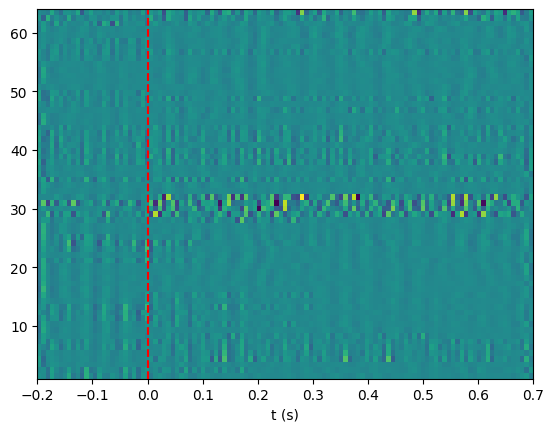

In [25]:
plt.imshow(all_trfs, aspect='auto', extent=[t_min,t_max,1,n_channels])
plt.axvline(0, color='r', linestyle='--') # audio onset
plt.xlabel('t (s)')

plt.show()

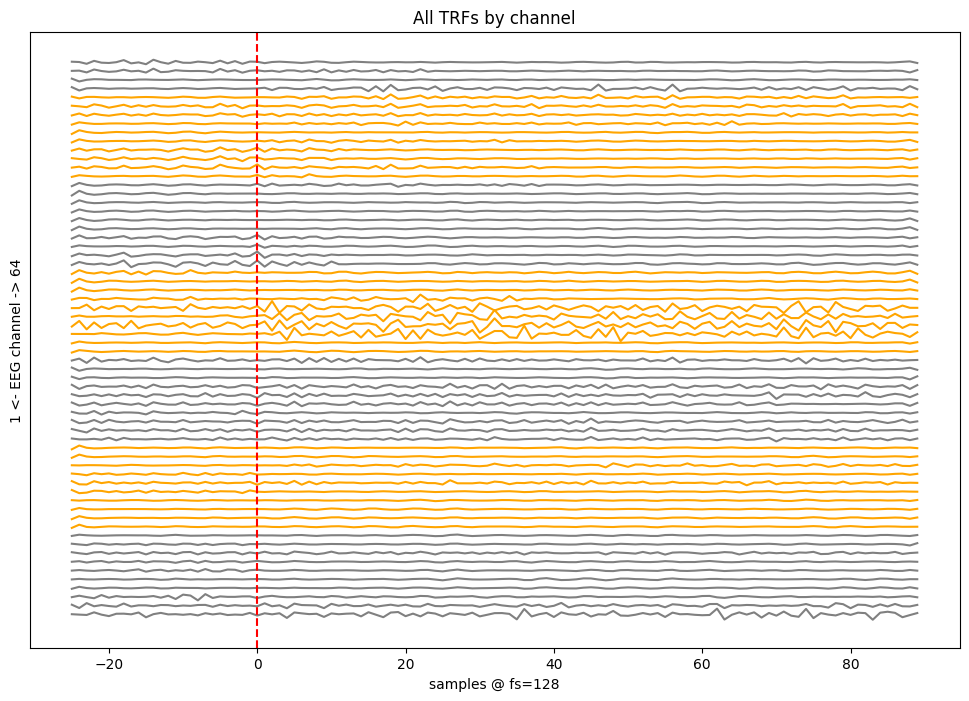

In [26]:
plt.figure(figsize=(12, 8))
for i, trf in enumerate(all_trfs):
    by_tens = math.floor(i/10)%2
    if by_tens==0:
        channel_color = 'grey'
    elif by_tens==1:
        channel_color = 'orange'
    else:
        channel_color = 'pink' # oops!
    plt.plot(lags, trf+(2*i), c=channel_color, label=f'ch{i}')

plt.axvline(x=0, c='red', ls='--')
plt.title(f'All TRFs by channel')
plt.xlabel(f'samples @ fs={fs_eeg}')
plt.ylabel('1 <- EEG channel -> 64')
plt.yticks([])
plt.show()